In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as model_select
from scipy.linalg import svd
from surprise import KNNWithMeans
from surprise import accuracy
from surprise import Dataset,Reader
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from collections import defaultdict

In [71]:
rating_pd = pd.read_csv("ratings_Electronics.csv")

In [72]:
rating_pd.head(5)

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [73]:
# Renaming Columns
rating_pd.columns=['userid','productid','rating','timestamp']

### Explore Data : 

In [74]:
rating_pd = rating_pd.drop(columns=['timestamp'])

In [75]:
rating_pd.head(5)

,userid,productid,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [76]:
rating_pd.shape

(7824481, 3)

##### Length of Unique User and Unique Length :

In [77]:
#unique user in system
len(rating_pd.userid.unique())

4201696

In [78]:
# unique Item in Sytem
len(rating_pd.productid.unique())

476001

### Extract users who rated more than 50 product :

In [79]:
# get those users who has given rating more than 50 product
rating_value_count = rating_pd['userid'].value_counts() > 50

In [80]:
rating_value_count = rating_value_count[rating_value_count].index.tolist()

In [81]:
filter_rating=rating_pd[rating_pd['userid'].isin(rating_value_count)]

In [82]:
filter_rating.shape

(122171, 3)

In [83]:
filter_rating.head(5)

,userid,productid,rating
117,AT09WGFUM934H,0594481813,3.0
176,A32HSNCNPRUMTR,0970407998,1.0
177,A17HMM1M7T9PJ1,0970407998,4.0
491,A3CLWR1UUZT6TG,0972683275,5.0
630,A3TAS1AG6FMBQW,0972683275,5.0


In [84]:
#taking only 10000 record from filter_rating_head to minimize calcultion time
filter_rating=filter_rating.head(10000)

### Histogram : 

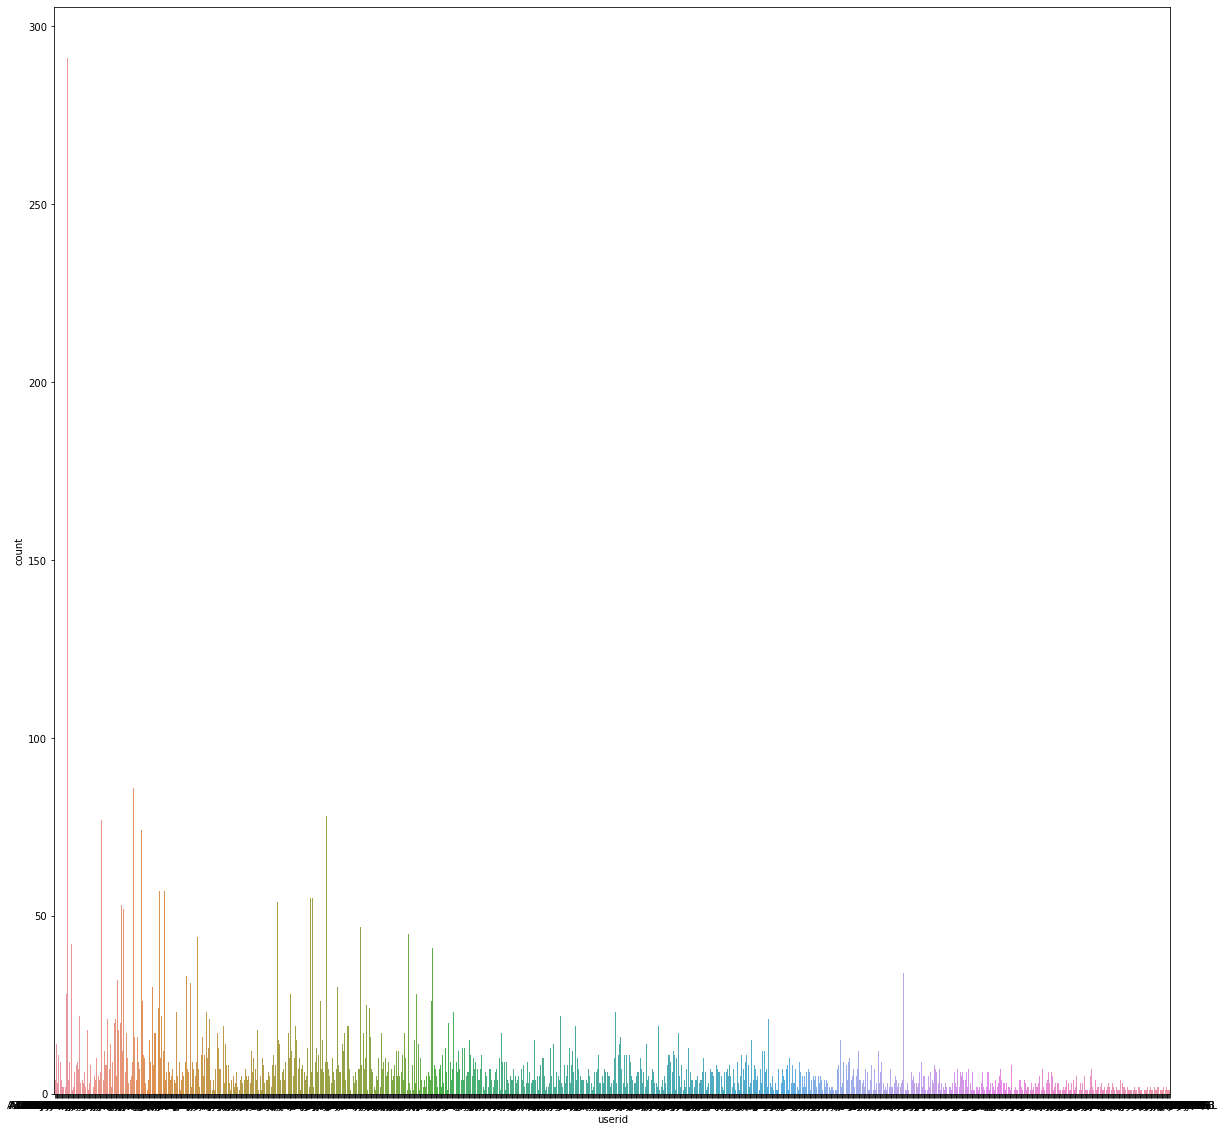

In [31]:
# histogram of User
a4_dims = (20, 20)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(filter_rating.userid,ax=ax)

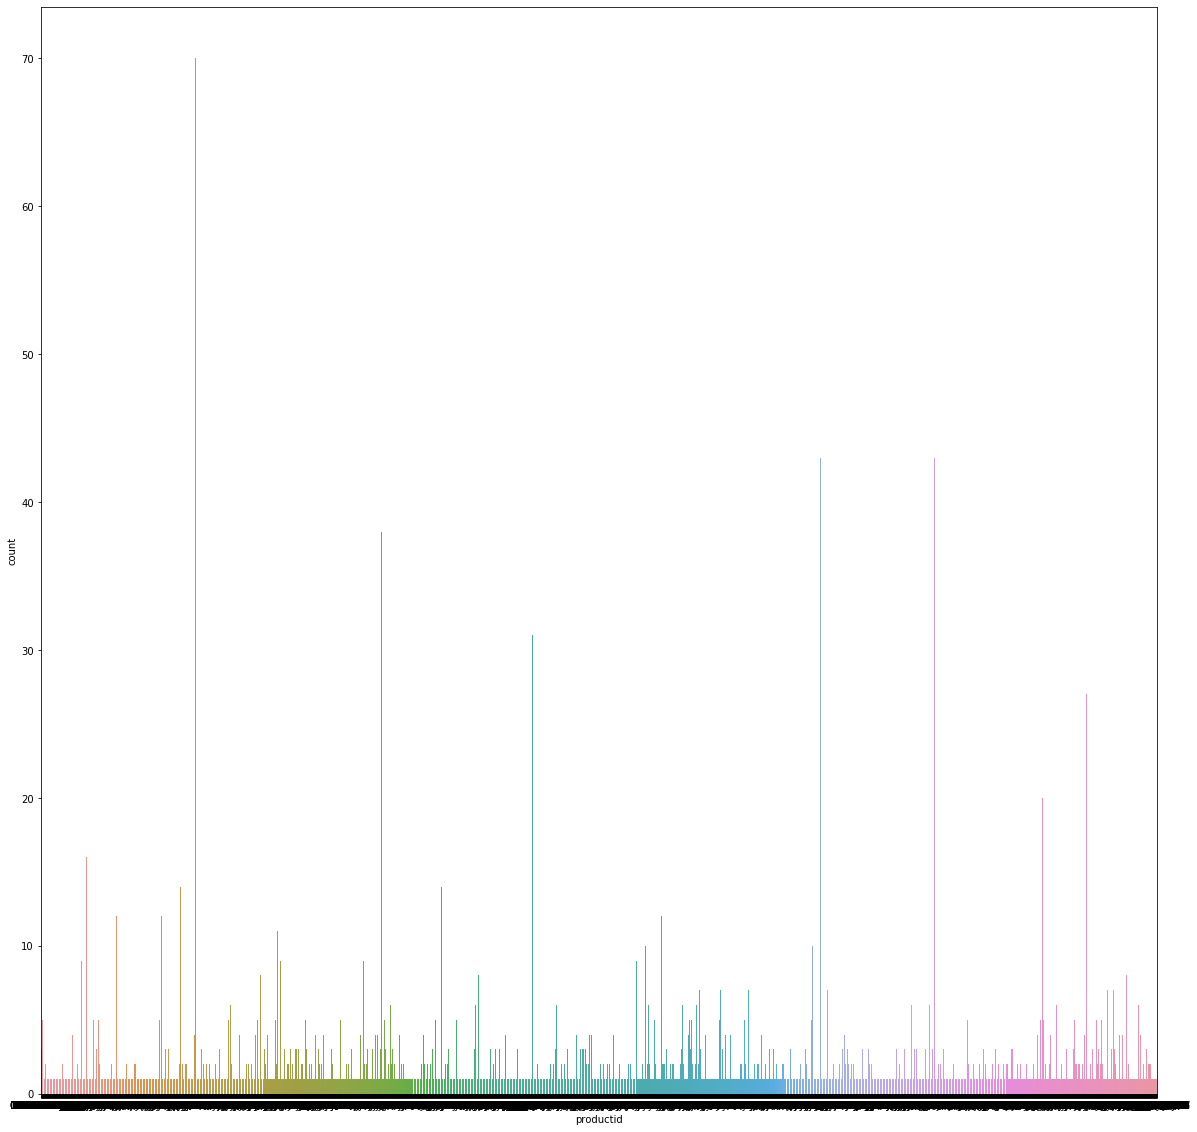

In [32]:
a4_dims = (20, 20)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(filter_rating.productid,ax=ax) 

In [85]:
#reindex of filter_rating dataset
filter_rating.index=[x for x in range(1,len(filter_rating.values)+1)]

## Popularity Based Recommendation System : 

### Simple Popularity System

In [86]:
#Popularity Based Recommended Model
pop_prdct=filter_rating.groupby('productid').agg(['count','mean'])

In [88]:
# mean_list=pop_prdct['rating']['mean']
#extract count and mean and make seperate DataFrame Containing productid,rating-count,mean-rating
mean_proc_list=[]
for index,row in pop_prdct.iterrows() :
    mean_proc_list.append([index,row['rating']['count'],row['rating']['mean']])

In [89]:
final_pop_prdct=pd.DataFrame(mean_proc_list,columns=['productid','rating-count','mean-rating'])

In [91]:
# sort the dataframe
final_pop_prdct.sort_values('mean-rating',ascending=False,inplace = True)

In [92]:
final_pop_prdct.head(5)

,productid,rating-count,mean-rating
1734,B000069E22,1.0,5.0
889,B000058TLP,2.0,5.0
846,B0000520IJ,1.0,5.0
847,B0000520IL,1.0,5.0
848,B0000520IT,1.0,5.0


### Weighted Popularity System

In [122]:
# Individial Product Count
V = final_pop_prdct['rating-count'] 
# Average Rating based on product
R = final_pop_prdct['mean-rating']
# all movie mean rating 
C = final_pop_prdct['mean-rating'].mean()
# minimum criteria to consinder to valid movie which are rated 
m = 5

In [123]:
final_pop_prdct['weighted_average'] = (V/(V+m) * R) + (m/(m+V) * C)

Text(0, 0.5, 'Product Id')

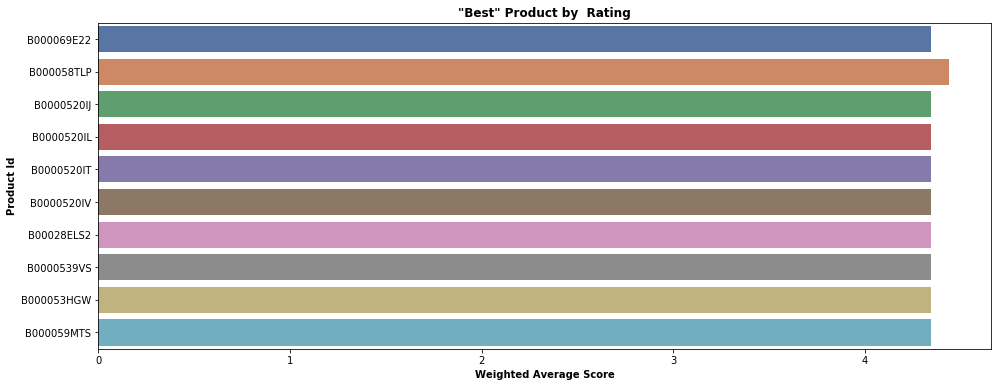

In [125]:
plt.figure(figsize=(16,6))

ax = sns.barplot(x=final_pop_prdct['weighted_average'].head(10), y=final_pop_prdct['productid'].head(10), data=final_pop_prdct, palette='deep')

#plt.xlim(6.75, 8.35)
plt.title('"Best" Product by  Rating', weight='bold')
plt.xlabel('Weighted Average Score', weight='bold')
plt.ylabel('Product Id', weight='bold')

### Precision & Recall

In [291]:
import random

class Precision_recall_calculator():
    
    def __init__(self, test_data, train_data):
        self.test_data = test_data
        self.train_data = train_data
        self.user_test_sample = None
        #self.model1 = pm
        self.pm_training_dict = dict()
        self.test_dict = dict()
    
    #Method to return random percentage of values from a list
    def remove_percentage(self, list_a, percentage):
        k = int(len(list_a) * percentage)
        random.seed(0)
        indicies = random.sample(range(len(list_a)), k)
        new_list = [list_a[i] for i in indicies]
    
        return new_list
        
    
    #Create a test sample of users for use in calculating precision
    #and recall
    def create_user_test_sample(self, percentage):
        #Find users common between training and test set
        users_test_and_training = list(set(self.test_data['userid'].unique()).intersection(set(self.train_data['userid'].unique())))
        #print("Length of user_test_and_training:%d" % len(users_test_and_training))

        #Take only random user_sample of users for evaluations
        self.users_test_sample = self.remove_percentage(users_test_and_training, percentage)

        #print("Length of user sample:%d" % len(self.users_test_sample))
        
    #Method to generate recommendations for users in the user test sample
    def get_test_sample_recommendations(self):
        #For these test_sample users, get top 10 recommendations from training set
        #self.ism_training_dict = {}
        self.pm_training_dict = {}

        self.test_dict = {}

        for user_id in self.users_test_sample:
            #print("Getting recommendations for user:%s" % user_id)
            #Get items for user_id from popularity model
            final_pop_prdct['userid']=user_id
            user_sim_items = final_pop_prdct
            self.pm_training_dict[user_id] = list(user_sim_items['productid'])
    
            #Get items for user_id from test_data
            test_data_user = self.test_data[self.test_data['userid'] == user_id]
            self.test_dict[user_id] = set(test_data_user['productid'].unique() )
    
    #Method to calculate the precision and recall measures
    def calculate_precision_recall(self) :
        #Create cutoff list for precision and recall calculation
        cutoff_list = list(range(1,11))


        #For each distinct cutoff:
        #    1. For each distinct user, calculate precision and recall.
        #    2. Calculate average precision and recall.

        
        pm_avg_precision_list = []
        pm_avg_recall_list = []


        num_users_sample = len(self.users_test_sample)
        for N in cutoff_list:
            
            pm_sum_precision = 0
            pm_sum_recall = 0
           
            pm_avg_precision = 0
            pm_avg_recall = 0

            for user_id in self.users_test_sample :
                pm_hitset = self.test_dict[user_id].intersection(set(self.pm_training_dict[user_id][0:N]))
                testset = self.test_dict[user_id]
                pm_sum_precision += float(len(pm_hitset))/float(N)
                pm_sum_recall += float(len(pm_hitset))/float(len(testset))
        
            pm_avg_precision = pm_sum_precision/float(num_users_sample)
            pm_avg_recall = pm_sum_recall/float(num_users_sample)
    
            pm_avg_precision_list.append(pm_avg_precision)
            pm_avg_recall_list.append(pm_avg_recall)
            
        return (pm_avg_precision_list, pm_avg_recall_list)
     

    #A wrapper method to calculate all the evaluation measures
    def calculate_measures(self, percentage):
        #Create a test sample of users
        self.create_user_test_sample(percentage)
        
        #Generate recommendations for the test sample users
        self.get_test_sample_recommendations()
        
        #Calculate precision and recall at different cutoff values
        #for popularity mode (pm) as well as item similarity model (ism)
        
        return self.calculate_precision_recall()  

In [292]:
train_data,test_data=model_select.train_test_split(filter_rating, test_size = 0.20, random_state=0)

In [293]:
precision_recall_calculator = Precision_recall_calculator(train_data,test_data)

In [294]:
pm_precision,pm_recall=precision_recall_calculator.calculate_measures(1)

In [301]:
# precision at k
pm_precision  

[0.0013003901170351106,
 0.0013003901170351106,
 0.0008669267446900737,
 0.0006501950585175553,
 0.0007802340702210665,
 0.0006501950585175553,
 0.0007430800668772059,
 0.000812743823146944,
 0.0008669267446900738,
 0.0009102730819245773]

In [303]:
# recall at k
pm_recall

[0.00016254876462938882,
 0.00022447210353582266,
 0.00022447210353582266,
 0.00022447210353582266,
 0.0002451132165046339,
 0.0002451132165046339,
 0.0004618449026771523,
 0.0005209535443605665,
 0.0005603593054828425,
 0.0006368528417790255]

## Collaboration Filter Based System : 

#### Used Surprise Package :

In [93]:
# collaboration filter based system using surprise Package
# preparing Dataset for Suprise Package
reader = Reader(rating_scale=(1, 5))
# taking top 100000 records to minimize calculation cost
filter_data=filter_rating.head(10000)

In [94]:
rating_data = Dataset.load_from_df(filter_data[['userid', 'productid', 'rating']], reader)

In [95]:
# split data into traing and test set
trainset, testset = train_test_split(rating_data, test_size=0.30,random_state=123)

In [220]:
sim_options = {
    "name": ["pearson"],
    "user_based": [False]
}
param_grid = {'k' : [5,10,15,20,25,30,35,40,45,50],"sim_options":sim_options}
#t_algo = KNNWithMeans(sim_options={'name': 'pearson', 'user_based': False})
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=3)
gs.fit(rating_data)

In [222]:
gs.best_params

{'rmse': {'k': 5, 'sim_options': {'name': 'pearson', 'user_based': False}}}

In [223]:
# train and build model using item-item approach
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson', 'user_based': False})
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [224]:
# evaluation of model using test set data
# Evalute on test set
test_pred = algo.test(testset)

# compute RMSE
accuracy.rmse(test_pred)

RMSE: 1.1810


1.1810372029001146

### Generating Top n recommedations

In [231]:
testset_new = trainset.build_anti_testset()

In [234]:
predictions = algo.test(testset_new[0:50000]) 

In [255]:
def get_top_n(predictions, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [256]:
top_10 = get_top_n(predictions) 

In [257]:
top_10['A2NVQZ4Y7Y0J1R']

[('B00009UTKF', 5),
 ('B000068NYF', 5),
 ('B00009R6UG', 5),
 ('B00004S9AK', 5),
 ('B00005V51W', 5),
 ('B00005K4PF', 5),
 ('B000065UWN', 5),
 ('B0000AQFZ9', 5),
 ('B00004TDLD', 5),
 ('B00006JPDF', 5)]

In [ ]:
# below is alternate way to extract top user wise recommendation

In [195]:
predictions_df = pd.DataFrame([[x.uid,x.iid,x.est] for x in predictions])

In [196]:
predictions_df.columns = ["userid","itemid","est_rating"]

In [198]:
# top 5 for user A2NVQZ4Y7Y0J1R
rec_5_A2NVQZ4Y7Y0J1R = predictions_df[predictions_df.userid=='A2NVQZ4Y7Y0J1R'].sort_values('est_rating',ascending=False)

In [201]:
rec_5_A2NVQZ4Y7Y0J1R[0:5]

,userid,itemid,est_rating
2000,A2NVQZ4Y7Y0J1R,B000068OEQ,5.0
2003,A2NVQZ4Y7Y0J1R,B00005V54U,5.0
1992,A2NVQZ4Y7Y0J1R,B0000C4G78,5.0
1994,A2NVQZ4Y7Y0J1R,B00006I57P,5.0
1995,A2NVQZ4Y7Y0J1R,B000062YJY,5.0


### Precision & Recall for CF

In [326]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    #Return precision and recall at k metrics for each user.

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    avg_precision=[]
    avg_recall=[]
    recalls = dict()
    for N in np.arange(1,k+1) :
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)
            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:N])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:N])

            # Precision@K: Proportion of recommended items that are relevant
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

            # Recall@K: Proportion of relevant items that are recommended
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
        
        precount = 0
        presum = 0
        for key in precisions:
            precount += 1
            presum += precisions[key]
                
        avg_precision.append(presum/precount) 
        reccount = 0
        recsum = 0
        for key in recalls:
            reccount += 1
            recsum += recalls[key]

        avg_recall.append(recsum/reccount)
        
    return avg_precision, avg_recall

In [327]:
cf_precisions, cf_recalls = precision_recall_at_k(test_pred, k=10, threshold=4)

In [328]:
cf_precisions

[0.8829465186680121,
 0.8708375378405651,
 0.8684830137907835,
 0.8662125798856374,
 0.8645475950218635,
 0.8642785065590314,
 0.863773965691221,
 0.863737927057806,
 0.8631492960453606,
 0.8633511123924847]

## Comparasion B/w Popularity & Collaboration Recommendation System

In [342]:
model_performance_df=pd.DataFrame({
             'pm_precision':pm_precision,
             'pm_recall':pm_recall})

In [349]:
model_performance_df['cfm_precision']=cf_precisions
model_performance_df['cfm_recall']=cf_recalls

In [354]:
model_performance_df

,pm_precision,pm_recall,cfm_precision,cfm_recall
0,0.001300,0.000163,0.882947,0.589386
1,0.001300,0.000224,0.870838,0.761688
2,0.000867,0.000224,0.868483,0.837436
3,0.000650,0.000224,0.866213,0.872528
4,0.000780,0.000245,0.864548,0.888514
5,0.000650,0.000245,0.864279,0.898080
6,0.000743,0.000462,0.863774,0.903302
7,0.000813,0.000521,0.863738,0.906903
8,0.000867,0.000560,0.863149,0.908972
9,0.000910,0.000637,0.863351,0.911537


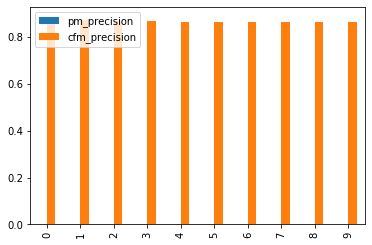

In [352]:
pd.DataFrame({'pm_precision':pm_precision,'cfm_precision':cf_precisions}).plot.bar()

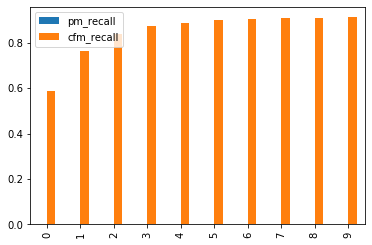

In [353]:
pd.DataFrame({'pm_recall':pm_recall,'cfm_recall':cf_recalls}).plot.bar()

## Conclusion